In [6]:
using QuantumOptics
using QuantumBayesian
using DifferentialEquations
using PyPlot

# Julia Stochastic Differential Equation Test

**Justin Dressel**, Dec 6, 2016 <br />
*Institute for Quantum Studies, Chapman University*

Using a simple qubit Rabi oscillation problem, test whether the built-in SDE solvers in the [DifferentialEquations](https://juliadiffeq.github.io/DiffEqDocs.jl/latest/tutorials/sde_example.html) package for Julia produce sensible results for even the simplest quantum problem of monitoring a single observable of a single qubit.

## Problem Specification

Consider a qubit orbiting in the x-z plane of the Bloch sphere with unit period, with continuous monitoring of the z observable.

### Qubit Hilbert Space

In [26]:
q = SpinBasis(1//2)
z = spinup(q)
zm = spindown(q)
y = (z + im*zm)/sqrt(2)
x = (z + zm)/sqrt(2)
Z = dm(z)
Zm = dm(zm)
Y = dm(y)
X = dm(x)

Operator(dim=2x2)
  basis: Spin(1/2)
 0.5+0.0im  0.5+0.0im
 0.5+0.0im  0.5+0.0im

### Global Constants

In [27]:
Ω  = 2*π;        # Rabi frequency
τ = 3.0;         # Measurement collapse timescale
Γ = 1/(2*τ);     # Measurement dephasing rate (quantum-limited efficiency)
T = (0.0, 3*τ);  # Time duration of simulation;

### Common Trajectory and Plotting Code

In [51]:
# Hamiltonian
H = (Ω/2)*Y.data;

# Measurement dephasing
DM = sqrt(Γ/2)*Z.data;

# Utilities
comm(a,b) = a * b' - b * a'
acomm(a, b) = a * b' + b * a'
sand(a, b) = a * b * a'
inn(a)  = ρ -> let ac = acomm(a, ρ);  ac - tr(ac)*ρ end
diss(a) = ρ -> sand(a, ρ) - acomm(a'*a, ρ)/2
expectation(ρ, op) = tr(ρ * op) / tr(ρ)

# Superoperators
dim = diss(DM)
mm = inn(sqrt(1/2)*DM)

# Deterministic part of evolution (Lindblad equation)
dρdt(ρ, p, t) = -im*comm(H, ρ) + dim(ρ)
dρdt2 = (du, ρ, p, t) -> du .= -im*comm(H, ρ) + dim(ρ) # SRIW1 no longer supports the inplace syntax above

# Ito stochastic part of evolution
dρdW(ρ, p, t) = mm(ρ)
dρdW2 = (du, ρ, p, t) -> du .= mm(ρ) # SRIW1 no longer supports the inplace syntax above

# Initial ground state
ρ0 = Zm.data;

In [52]:
# Plotting
function plot_solution(sol; plot_title="Monitored Rabi Oscillation")
    ts = range(T..., length=length(sol))
    @info("Timesteps: ",length(sol))
    # Get Bloch components
    xs = zeros(Float64, size(ts)) 
    ys = zeros(Float64, size(ts))
    zs = zeros(Float64, size(ts))
    for i in 1:length(sol)
        xs[i] = 2real(expectation(sol[i], X.data) - 0.5)
        ys[i] = 2real(expectation(sol[i], Y.data) - 0.5)
        zs[i] = 2real(expectation(sol[i], Z.data) - 0.5)
    end
    # Plot Bloch components vs. time
    p = plot(ts, xs, label=L"$x$")
    plot(ts, ys, label=L"$y$")
    ax = gca()
    ax.set_ylim([-1.1,1.1]) 
    plot(ts, zs, label=L"$z$")
    xlabel(L"$t/\tau$")
    ylabel("Bloch coordinates")
    title(plot_title)
    legend()
    show()
end;

## Simulation and Plots

Define the problem, with moderate duration to show expected behavior.

In [53]:
probsde = SDEProblem(dρdt, dρdW, ρ0, T);
probsde2 = SDEProblem(dρdt2, dρdW2, ρ0, (0,6*2pi)); # SRIW1 no longer supports the inplace syntax above
probode = ODEProblem(dρdt, ρ0, T);

### Lindblad Euler evolution

Plot a reference unmonitored oscillation to verify Lindblad evolution is as expected. Use the explicitly first-order Euler method as a benchmark. The solution converges to acceptable precision by $dt=10^{-4}$.

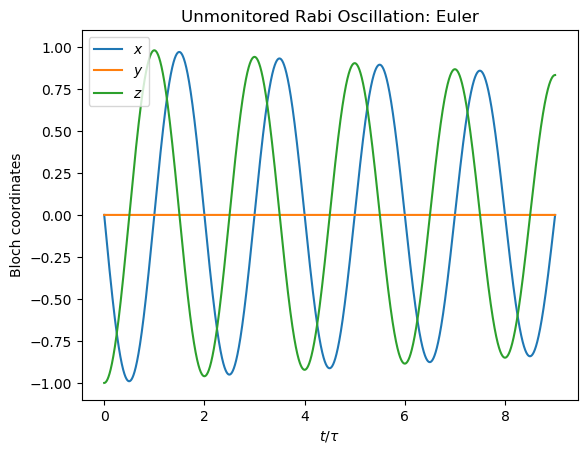

  0.938632 seconds (3.11 M allocations: 292.437 MiB, 15.18% gc time)


┌ Info: Timesteps: 
│   length(sol) = 90002
└ @ Main In[52]:4


In [54]:
@time sol = solve(probode, Euler(), dt=1/10^4)

plot_solution(sol, plot_title="Unmonitored Rabi Oscillation: Euler")

Compare this to a 4th-order Runge-Kutta method with $dt=10^{-2}$, for completeness.

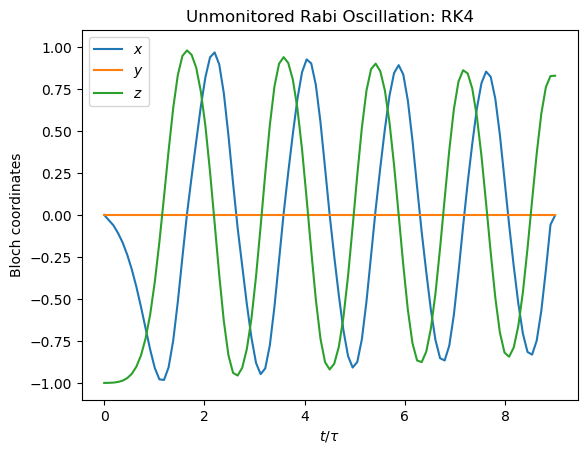

  1.979520 seconds (5.02 M allocations: 269.954 MiB, 3.20% gc time)


┌ Info: Timesteps: 
│   length(sol) = 99
└ @ Main In[52]:4


In [55]:
@time sol = solve(probode, RK4(), dt=1/10^2);

plot_solution(sol, plot_title="Unmonitored Rabi Oscillation: RK4")

### Euler-Marayama SME

Now, try the Euler-Marayama method, which is also an explicit first-order time-stepped method. Try both $dt=10^{-4}$ and $dt=10^{-5}$ to check convergence.  **Importantly: any excursions beyond the bounds of $\pm 1$ are unphysical, and indicative of a numerical precision failure.**

 11.853641 seconds (31.29 M allocations: 7.547 GiB, 13.18% gc time)


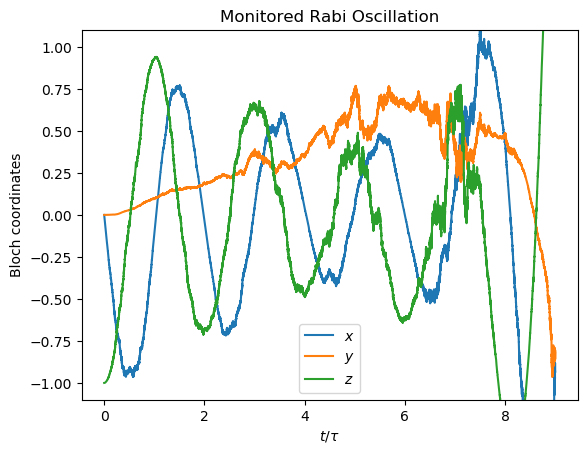

┌ Info: Timesteps: 
│   length(sol) = 90002
└ @ Main In[52]:4


In [56]:
@time sol = solve(probsde, EM(), dt=1/10^4);

plot_solution(sol)

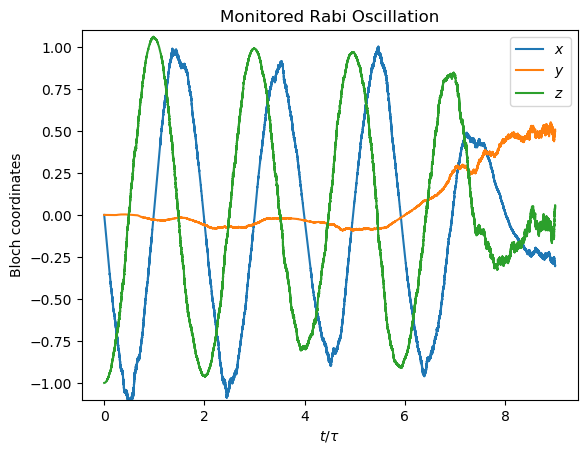

  4.947818 seconds (29.70 M allocations: 3.225 GiB, 28.99% gc time)


┌ Info: Timesteps: 
│   length(sol) = 900002
└ @ Main In[52]:4


In [57]:
@time sol = solve(probsde, EM(), dt=1/10^5);

plot_solution(sol)

Note that the first-order method yields unacceptable precision at $dt=10^{-4}$, which does not appreciably improve with an order of magnitude decrease in stepsize. This makes simulation of ensembles prohibitive.

### Rossler 1.5 SME

Next, try the explicitly order 1.5 Rossler method suitable for diagonal/scalar SDE, which should show improved precision over the order 1 EM method.

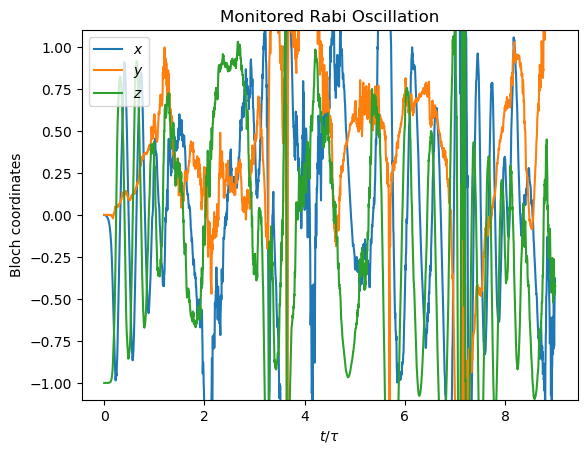

 22.046806 seconds (50.27 M allocations: 8.124 GiB, 25.24% gc time)


┌ Info: Timesteps: 
│   length(sol) = 2376
└ @ Main In[52]:4


In [58]:
@time sol = solve(probsde2, SRIW1(), dt=1/10^4);

plot_solution(sol)

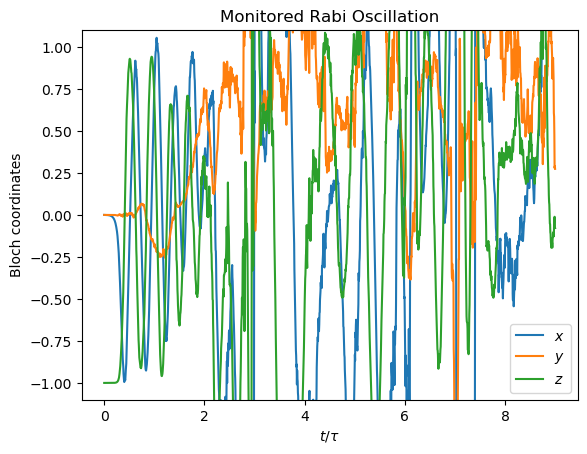

  0.012776 seconds (117.96 k allocations: 12.367 MiB)


┌ Info: Timesteps: 
│   length(sol) = 1798
└ @ Main In[52]:4


In [59]:
@time sol = solve(probsde2, SRIW1(), dt=1/10^5);

plot_solution(sol)

This also does not produce acceptable precision, despite the higher-order method.

### Runge-Kutta Milstein SME
Next, try the Order-1.0 RKMilstein method.

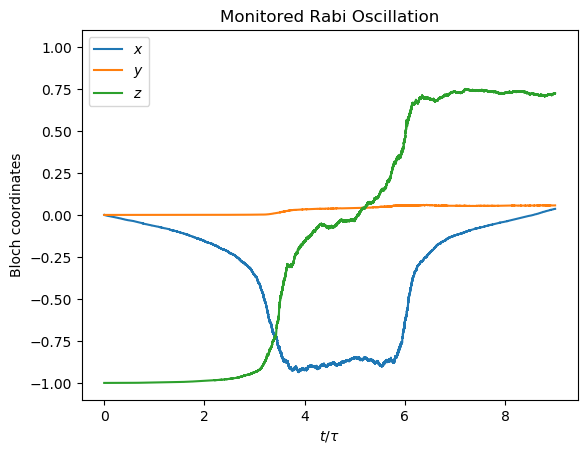

 38.440422 seconds (185.03 M allocations: 17.190 GiB, 13.29% gc time)


┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /Users/luke/.julia/packages/DiffEqBase/xG5ve/src/integrator_interface.jl:329
┌ Info: Timesteps: 
│   length(sol) = 999705
└ @ Main In[52]:4


In [60]:
@time sol = solve(probsde, RKMil(), dt=1/10^4);

plot_solution(sol)

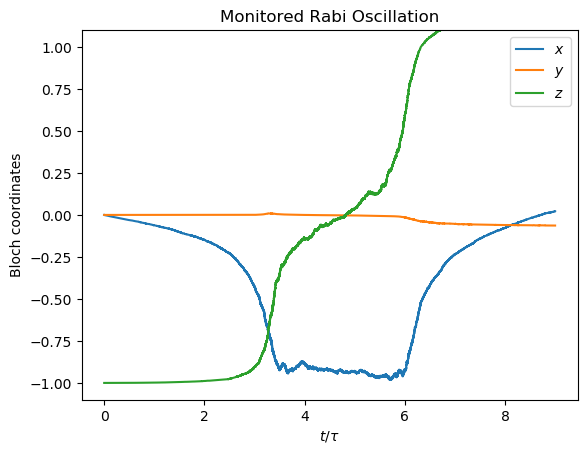

 23.740702 seconds (159.00 M allocations: 10.083 GiB, 13.39% gc time)


┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /Users/luke/.julia/packages/DiffEqBase/xG5ve/src/integrator_interface.jl:329
┌ Info: Timesteps: 
│   length(sol) = 999639
└ @ Main In[52]:4


In [61]:
@time sol = solve(probsde, RKMil(), dt=1/10^5);

plot_solution(sol)

This performance is not notably better for $dt=10^{-5}$.

## Conclusions

None of the currently implemented stochastic integration methods are suitable for integrating even the simplest problem of monitored qubit dynamics.

## Version Information

In [62]:
versioninfo()

Julia Version 1.4.1
Commit 381693d3df* (2020-04-14 17:20 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i7-7660U CPU @ 2.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, skylake)
